The aim of this notebook is to apply a MLP and a CNN on the FashionMNIST dataset (multiclass classification problem).
In this version of the notebook, we wrote functions for the training, test, visualisation of the models, as well as a confusion matrix, to know where the
models are wrong.

JB  21/05/23

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm

In [2]:
train_data = FashionMNIST('./', train= True, transform = ToTensor(), download= True)
test_data  = FashionMNIST('./', train= False, transform = ToTensor(), download= True)

100%|██████████| 26421880/26421880 [00:02<00:00, 11956948.30it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 199495.41it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3766071.06it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8926116.99it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [3]:
batch_size = 32
train_data_loader =  DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data_loader  =  DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [5]:
classes = train_data.classes
dict_classes = {0:'T-shirt/top', 1:'Trouser', 2: 'Pullover', 3: 'Dress',4: 'Coat',5: 'Sandal', 6: 'Shirt',7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

In [6]:
class DNN(nn.Module):
  
    def __init__(self, input_features:int, hidden_features:int, output_features:int):
        super().__init__()
        self.stack_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_features, out_features= hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features= output_features),
            nn.Softmax(dim=1)
        )

    def forward(self, X: torch.tensor)-> torch.tensor:
        return self.stack_layer(X)

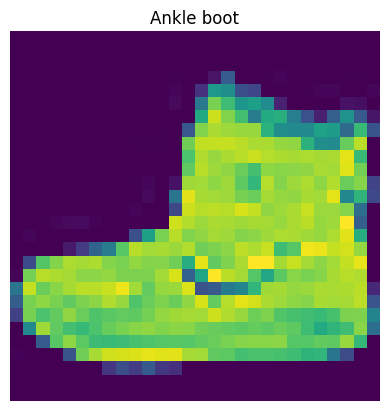

In [7]:
fig, ax = plt.subplots()
ax.imshow(train_data[0][0].squeeze().numpy())
ax.set_title(dict_classes[train_data[0][1]])
ax.set_axis_off()

In [9]:
dnn.state_dict();

In [54]:
def train_model(n_epoch:int, n_samples:int, n_classes:int, model: nn.Module, loss_function: nn.modules.loss, optimizer:torch.optim, train_data_loader: DataLoader, device: torch.device):
    
    model.to(device)
    model.train()
    loss_train, acc = 0, 0
    for (X,y) in train_data_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss   = loss_fn(y_pred, nn.functional.one_hot(y, num_classes= n_classes).type(torch.float32))
        acc    = acc + (y_pred.argmax(dim=1) == y).sum()
        loss_train = loss_train + loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (n_epoch % n_samples)==0:        
        loss_train = loss_train/len(train_data_loader)
        acc = acc/(len(train_data_loader)*train_data_loader.batch_size)
        return loss_train.detach().item(), acc.detach().item()
    else:
        return np.nan, np.nan    

In [56]:
def test_model(n_epoch:int, n_samples:int, n_classes:int , model: nn.Module, test_data_loader: DataLoader, device: torch.device):

    loss_train, acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for (X,y) in test_data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss   = loss_fn(y_pred, nn.functional.one_hot(y, num_classes= n_classes).type(torch.float32))
            acc    = acc + (y_pred.argmax(dim=1) == y).sum()
            loss_train = loss_train + loss

        if (n_epoch % n_samples)==0:        
            loss_train = loss_train/len(test_data_loader)
            acc = acc/(len(test_data_loader)*test_data_loader.batch_size)
            return loss_train.detach().item(), acc.detach().item()
        else:
            return np.nan, np.nan         

In [131]:
def train_test_model(n_epochs:int, n_samples:int, n_classes:int, model:nn.Module, loss_function:nn.modules.loss, optimizer:torch.optim, train_data_loader: DataLoader, test_data_loader: DataLoader, device: torch.device):
    """
    n_epochs: number of passes for all the training data
    n_samples: one every n_samples, save the loss and the accuracy. 
    n_classes: number of classes
    model: model to test
    loss_function: loss function (can be BCELoss for instance)
    optimizer: (for instance nn.) 
    """

    loss_train_epochs = []
    loss_test_epochs  = []
    acc_train_epochs  = []
    acc_test_epochs   = []
    num_epoch         = []

    for n_epoch in tqdm(range(n_epochs)):

        loss_temp_train, acc_temp_train = train_model(n_epoch, n_samples, n_classes, model, loss_function, optimizer, train_data_loader, device)
        loss_temp_test, acc_temp_test = test_model(n_epoch, n_samples, n_classes , model, test_data_loader, device)

        if ((n_epoch %n_samples) == 0):
            loss_train_epochs.append(loss_temp_train)
            loss_test_epochs.append(loss_temp_test)
            acc_train_epochs.append(acc_temp_train)
            acc_test_epochs.append(acc_temp_test)
            num_epoch.append(n_epoch)

    return loss_train_epochs, acc_train_epochs, loss_test_epochs, acc_test_epochs, num_epoch

In [64]:
def plot_results(num_epoch, loss_train_epochs, acc_train_epochs, loss_test_epochs, acc_test_epochs):

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
    ax1.plot(num_epoch, loss_train_epochs, label = 'train')
    ax1.plot(num_epoch, loss_test_epochs, label= 'test')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('loss')
    ax1.legend()
 
    ax2.plot(num_epoch, acc_train_epochs, label = 'train')
    ax2.plot(num_epoch, acc_test_epochs, label= 'test')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.legend()


In [121]:
def prediction(model, test_data_loader, device: torch.device):
    model.to(device)
    model.eval()
    list_gt = []
    list_pred = []
    with torch.inference_mode():
        for (X,y) in test_data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X).argmax(dim=1)
            
            list_gt.append(y)
            list_pred.append(y_pred)
    
    return list_gt, list_pred

In [122]:
def confusion_matrix( list_gt, list_pred, classes):
    # vertical dimension: GT
    # horizontal dimension: Predicted
    
    n_classes = len(classes)
    CM = np.zeros((len(classes),len(classes)))
    for (l_gt, l_pred) in zip(list_gt, list_pred):
      for (gt, pred) in zip(l_gt, l_pred):
        CM[gt.item(), pred.item()] += 1

    fig, ax = plt.subplots()
    ax.imshow(CM, cmap= 'spring')
    ax.set_xticks(np.arange(n_classes),classes, rotation=45);
    ax.set_yticks(np.arange(n_classes),classes, rotation=0);
    for (j,i),label in np.ndenumerate(CM):
        ax.text(i,j,int(label),ha='center',va='center')
 

In [126]:
# DNN : model 1
torch.manual_seed(456)
dnn =  DNN(input_features=28*28, hidden_features= 20, output_features=len(classes))
lr = 0.1
n_samples = 5
n_classes = len(dict_classes)
model = dnn
loss_f = nn.BCELoss()
optimizer = torch.optim.SGD(dnn.parameters(),lr = lr)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [127]:
 loss_train_epochs, acc_train_epochs, loss_test_epochs, acc_test_epochs, num_epoch = train_test_model(n_epochs = 30, n_samples=5, n_classes= len(dict_classes),
                                                                                           model=dnn, loss_function= loss_f, optimizer = optimizer, 
                                                                                           train_data_loader= train_data_loader, test_data_loader= test_data_loader,
                                                                                           device= device)

100%|██████████| 30/30 [07:41<00:00, 15.38s/it]


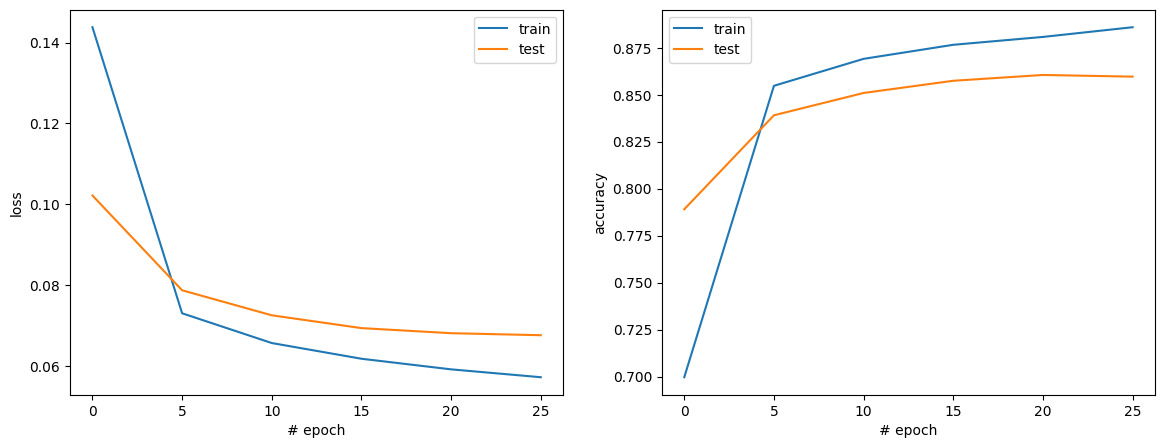

In [128]:
plot_results(num_epoch, loss_train_epochs, acc_train_epochs, loss_test_epochs, acc_test_epochs)

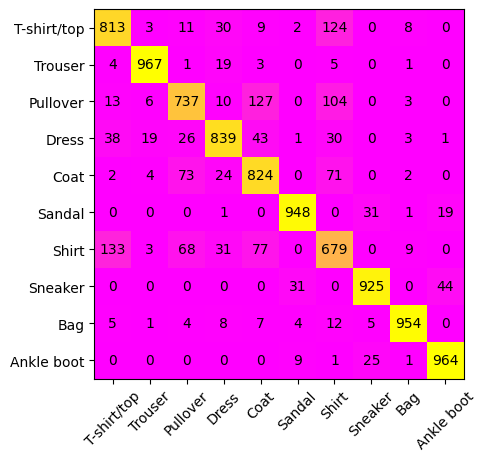

In [130]:
 # make predicions, plot confusion matrix
list_gt, list_pred = prediction(dnn, test_data_loader, device)
confusion_matrix(list_gt, list_pred, classes)

In [66]:
#CNN model 2

In [74]:
class CNN(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) ,
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape),
            nn.Softmax(dim= 1)
        )
    
    def forward(self, x: torch.Tensor):
        x1 = self.block_1(x)
        x2 = self.block_2(x1)
        x3 = self.classifier(x2)
        return x3

In [86]:
torch.manual_seed(456)
cnn =  CNN(input_shape=1, hidden_units= 10, output_shape=len(dict_classes))
lr = 0.1
n_samples = 5
n_classes = len(dict_classes)
model = cnn
loss_f = nn.BCELoss()
optimizer = torch.optim.SGD(cnn.parameters(),lr = lr)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [87]:
loss_train_epochs, acc_train_epochs, loss_test_epochs, acc_test_epochs, num_epoch = train_test_model(n_epochs = 30, n_samples=5, n_classes= len(dict_classes),
                                                                                           model=cnn, loss_function= loss_f, optimizer = optimizer, 
                                                                                           train_data_loader= train_data_loader, test_data_loader= test_data_loader,
                                                                                           device= device)

100%|██████████| 30/30 [27:23<00:00, 54.78s/it]


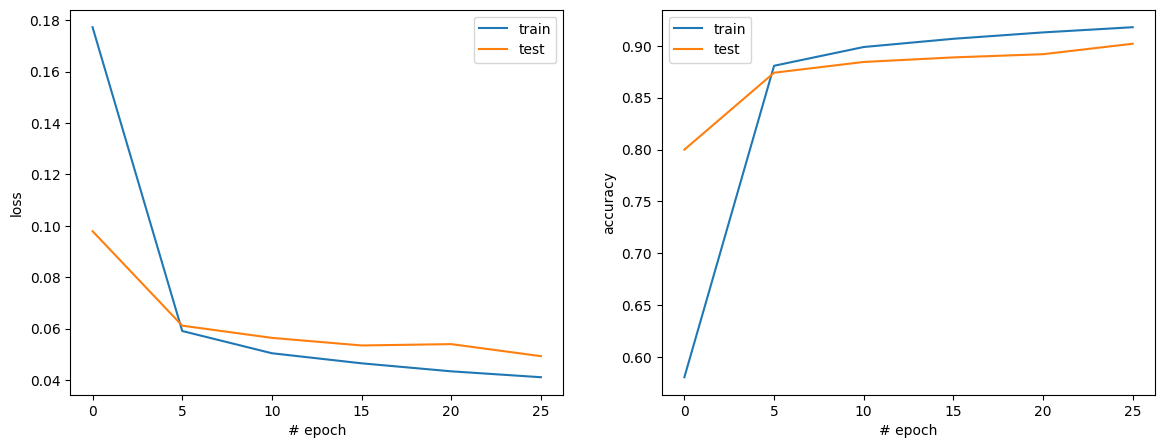

In [88]:
plot_results(num_epoch, loss_train_epochs, acc_train_epochs, loss_test_epochs, acc_test_epochs)

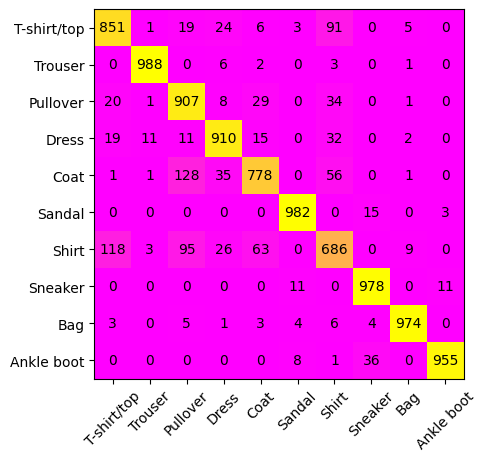

In [123]:
 # make predicions, plot confusion matrix
list_gt, list_pred = prediction(model, test_data_loader, device)
confusion_matrix(list_gt, list_pred, classes)